# Work FLow
- `Packages and Libraries`
-  `Load raw audio data` from files in .WAV format that can be processed
-  `EDA`
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.
-  `Converting to TFLite model`

# Packages and Libraries

In [1]:
import os
import pathlib
import wave
import shutil

import librosa

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import soundfile as sf

import IPython.display as display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

SAMPLE_RATE = 16000

2024-03-06 22:42:54.125657: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 22:42:54.173812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 22:42:54.173856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 22:42:54.174926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 22:42:54.181375: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 22:42:54.182408: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Loading Raw Audio Data File Paths

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each voice command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

In [2]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

PROCESS_TRAIN_DATASET_PATH = 'Dataset/Process_train'
PROCESS_TEST_DATASET_PATH = 'Dataset/Process_test'


train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

process_train_data_dir = pathlib.Path(PROCESS_TRAIN_DATASET_PATH)
process_test_data_dir = pathlib.Path(PROCESS_TEST_DATASET_PATH)

# Functions

## 1. Duration(2s), and channel (mono) check function

In [3]:
def move_audio_files(data_dir, process_folder):
    if not os.path.exists(process_folder):
        os.makedirs(process_folder)

    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)
                try:
                    # Get audio length and number of channels
                    with wave.open(audio_path, 'r') as wav_file:
                        audio_length = wav_file.getnframes() / wav_file.getframerate()
                        num_channels = wav_file.getnchannels()

                    if audio_length > 2.0 or num_channels != 1:
                        # Move the audio file to the process folder
                        shutil.move(audio_path, os.path.join(process_folder, audio_file))
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")


move_audio_files(train_data_dir, process_train_data_dir)
move_audio_files(test_data_dir, process_test_data_dir)

## 2. Count audio files function

In [4]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count
    return counts

## 3. Function to determine the size of the model

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Exploratory Data Analysis (EDA) 

## Labels (Train and Test Directories)

In [6]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
print(f'Train commands labels: {commands}')

commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
print(f'Test commands labels:  {commands}')

Train commands labels: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']
Test commands labels:  ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files

### 1. Training dataset

In [7]:
counts = count_audio_files_in_subfolders(train_data_dir)
print(f'Train \n{counts}')
print()

Train 
{'emabega': 1539, 'ddyo': 1564, 'gaali': 1437, 'kkono': 1595, 'mu masso': 1565, 'yimirira': 1504}



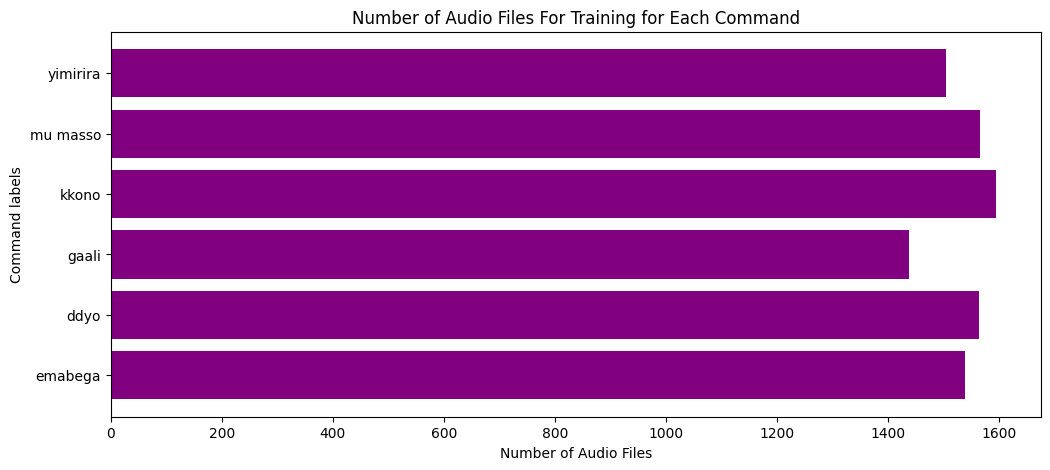

In [8]:
plt.figure(figsize=(12, 5))
plt.barh(list(counts.keys()), list(counts.values()), color='purple')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### 2. Test dataset

In [9]:
counts = count_audio_files_in_subfolders(test_data_dir)
print(f'Test \n{counts}')
print()

Test 
{'emabega': 302, 'ddyo': 302, 'gaali': 307, 'kkono': 310, 'mu masso': 306, 'yimirira': 305}



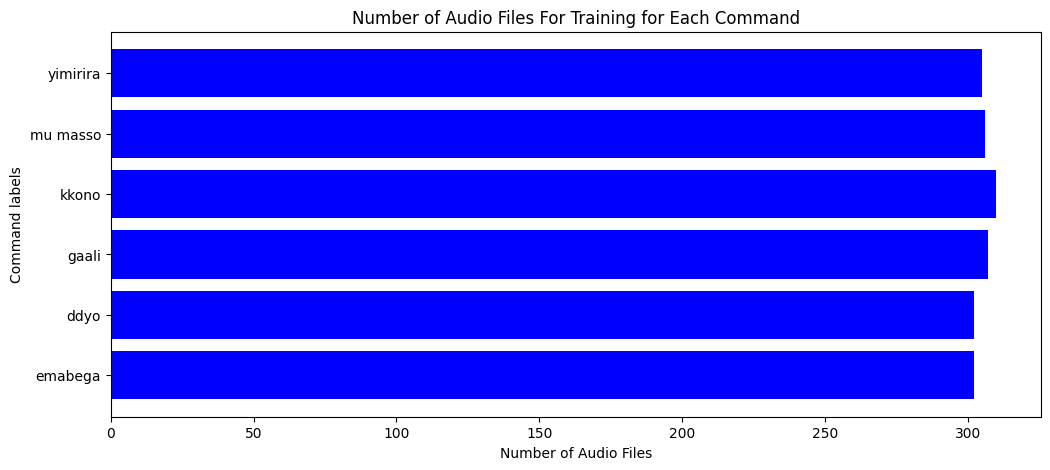

In [10]:
plt.figure(figsize=(12, 5))
plt.barh(list(counts.keys()), list(counts.values()), color='blue')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

## Audio Properties and Parameters
- using one audio file

In [11]:
example_audio_path = os.path.join(TRAIN_DATASET_PATH, 'ddyo', 'ddyo #107.wav')
audio_signal, sample_rate = librosa.load(example_audio_path, sr=SAMPLE_RATE)
audio = wave.open(example_audio_path, 'rb')

In [12]:
num_channels = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
num_frames = audio.getnframes()
duration = num_frames / float(frame_rate)

In [13]:
print('Audio Properties for a ddyo audio file')
print(f"Number of channels:   {num_channels}")
print(f"Sample width (bytes): {sample_width}")
print(f"Frame rate (Hz):      {frame_rate}")
print(f"Number of frames:     {num_frames}")
print(f"Duration (s):         {duration}")
# print("Parameters:            ", audio.getparams())
audio.close()

Audio Properties for a ddyo audio file
Number of channels:   1
Sample width (bytes): 2
Frame rate (Hz):      16000
Number of frames:     21440
Duration (s):         1.34


## Visualize the audio waveform

In [14]:
ddyo_file_path = os.path.join(TRAIN_DATASET_PATH, 'ddyo', 'ddyo #107.wav')
kkono_file_path = os.path.join(TRAIN_DATASET_PATH, 'kkono', 'kkono #67.wav')
emabega_file_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'emabega #225.wav')
mumasso_file_path = os.path.join(TRAIN_DATASET_PATH, 'mu masso', 'mu masso #140.wav')
yimirira_file_path = os.path.join(TRAIN_DATASET_PATH, 'yimirira', 'yimirira-3 #58-05.wav')
gaali_file_path = os.path.join(TRAIN_DATASET_PATH, 'gaali', 'gaali #371.wav')

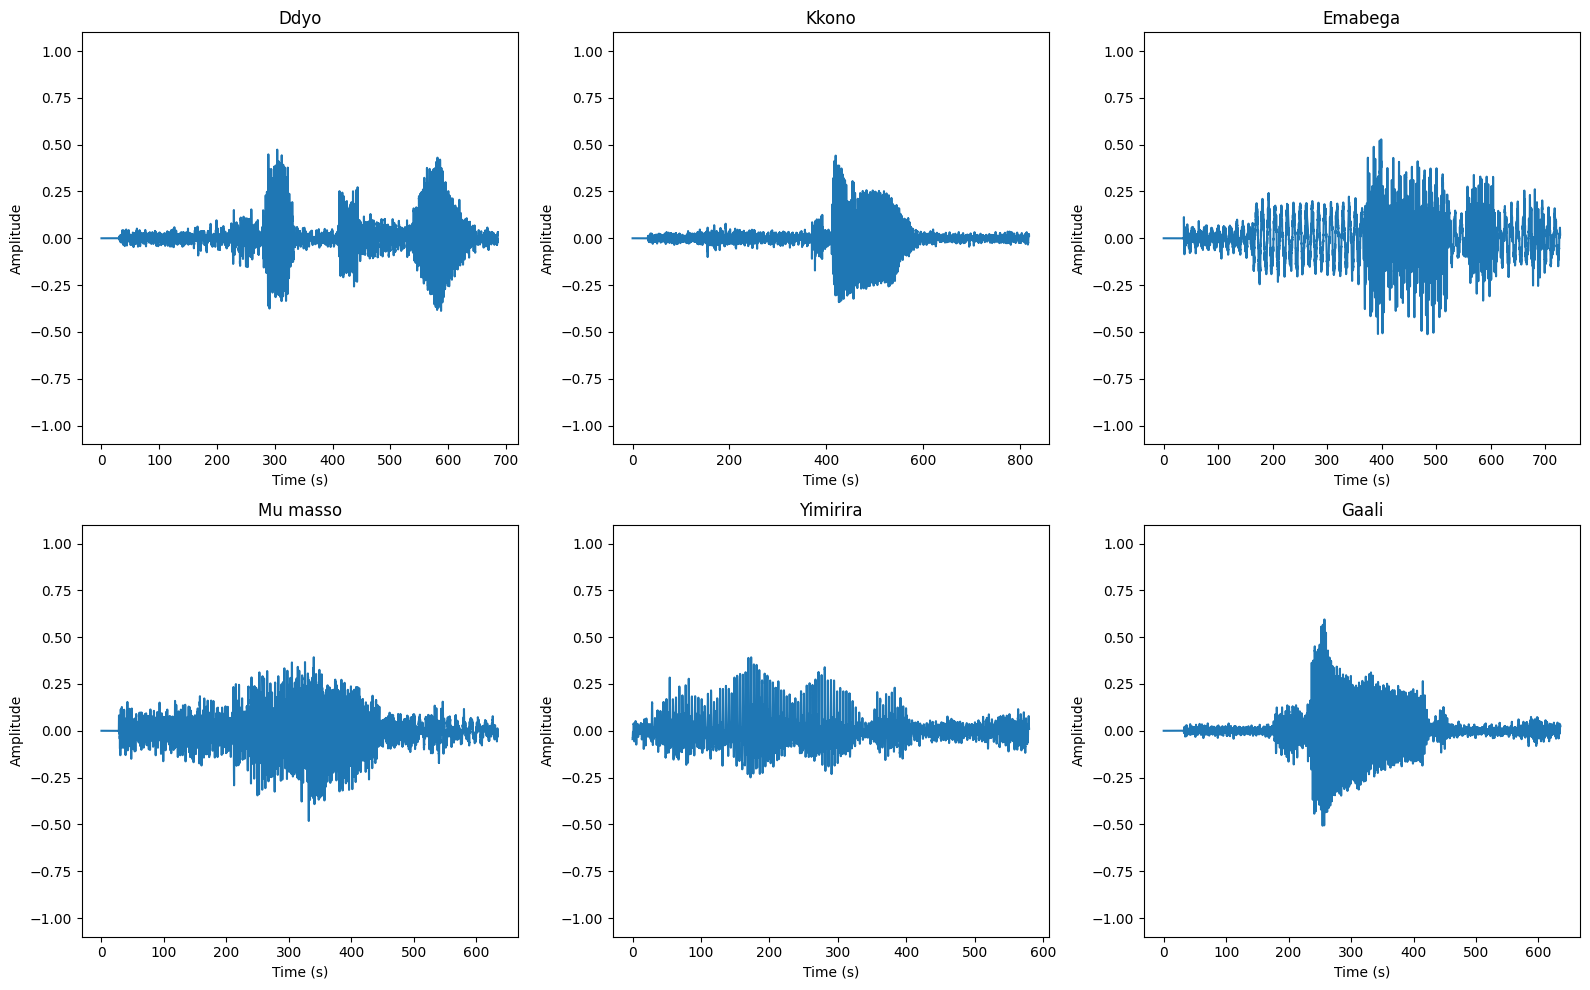

In [15]:
audio_files = [
    ddyo_file_path,
    kkono_file_path,
    emabega_file_path,
    mumasso_file_path,
    yimirira_file_path,
    gaali_file_path
]

label_names_slice = ['Ddyo', 'Kkono', 'Emabega', 'Mu masso', 'Yimirira', 'Gaali']

plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_path = audio_files[i]  # Get the path to the audio file
    audio_signal, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)
    plt.plot(time, audio_signal)
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()


## Play audio file

Ddyo

In [16]:
display.Audio(ddyo_file_path)

Kkono

In [17]:
display.Audio(kkono_file_path)

Emabega

In [18]:
display.Audio(emabega_file_path)

Mu masso

In [19]:
display.Audio(mumasso_file_path)

Yimirira

In [20]:
display.Audio(yimirira_file_path)

Gaali

In [21]:
display.Audio(gaali_file_path)

# Dataset Preparaption

## 1. Train and validation Datasets

In [22]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()

Found 9204 files belonging to 6 classes.
Using 7364 files for training.
Using 1840 files for validation.



In [23]:
element_spec = train_ds.element_spec
print(element_spec)
print()

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))



In [24]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [25]:
# Inspecting the shape of the audio and label

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


## 2. Test dataset

In [26]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=64,
    validation_split=None,  # No need to split the test dataset
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    shuffle=False  # Disable shuffling for the test dataset
)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

# Shard the test dataset
test_ds = test_ds.shard(num_shards=2, index=0)
print()

Found 1832 files belonging to 6 classes.



In [27]:
for example_audio, example_labels in test_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)
print()

(64, 16000)
(64,)



# Feature Extraction

In [28]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Tensorized waveform
The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio.

In [29]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Visualization of spectrogram

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform and spectrogram.

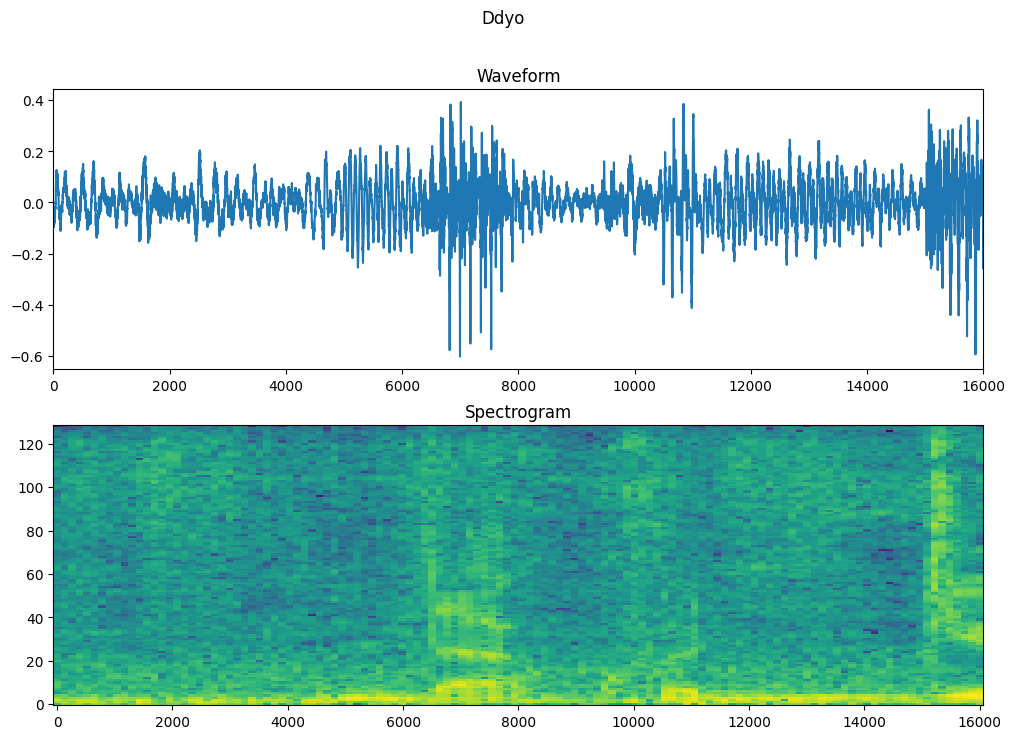

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets

In [32]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [34]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [35]:
train_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
val_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
test_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Visualization of the spectrograms

In [38]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

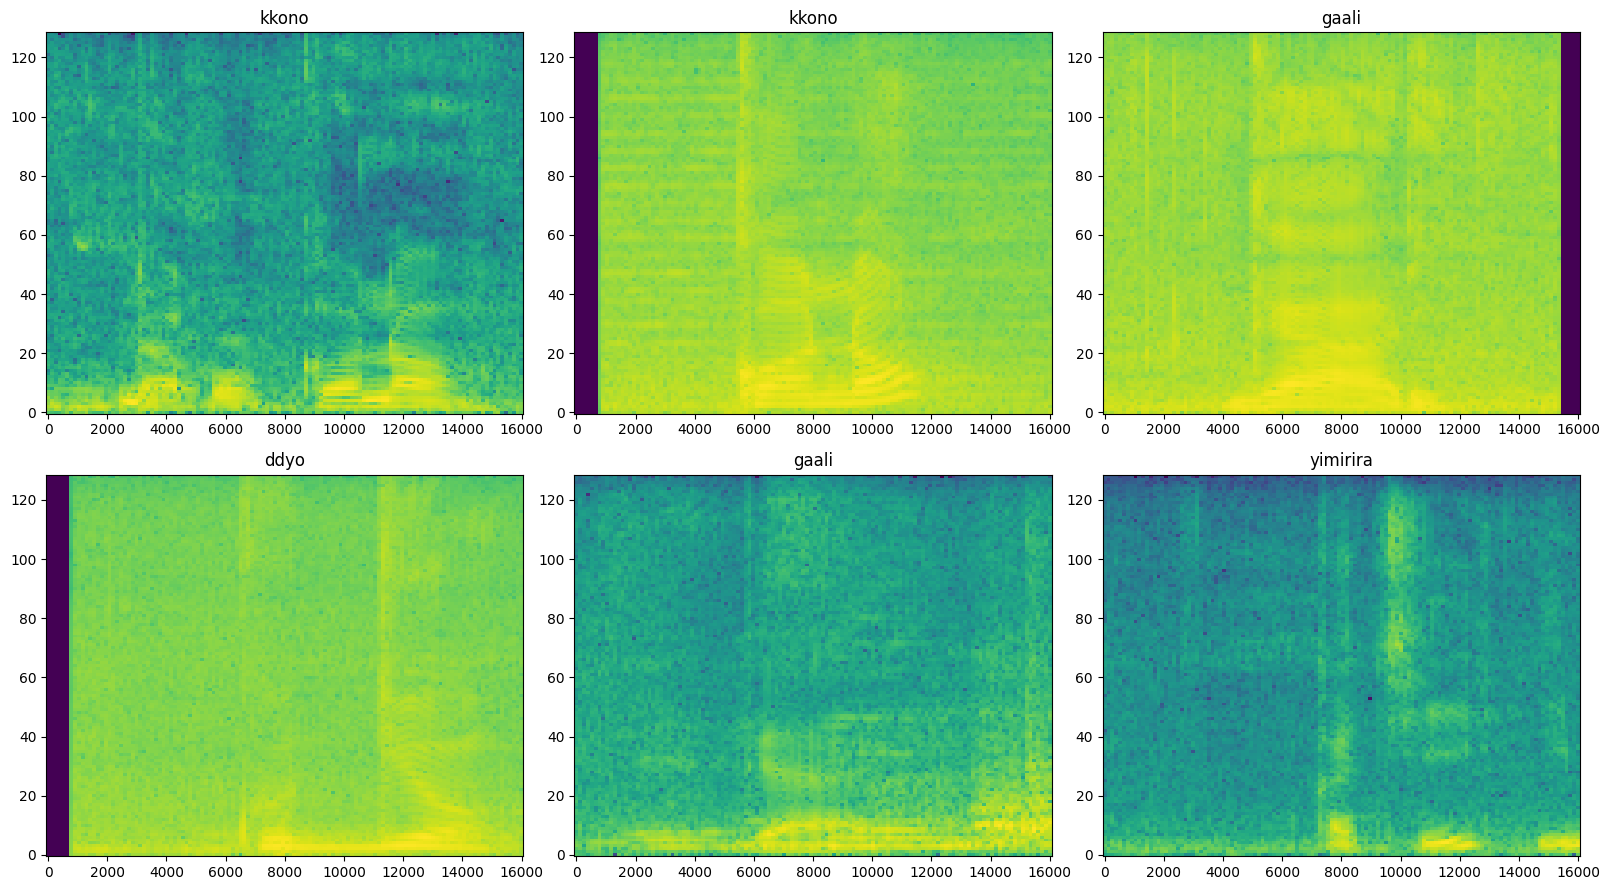

In [39]:
rows = 2
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.tight_layout()
plt.show()


# Building Models

# Building Models

## Model 1

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [40]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)


Input shape: (124, 129, 1)


### Normalization layer

In [41]:
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Model Arch

In [42]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0

### Compile the model

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [44]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
116/116 [==============================] - 103s 879ms/step - loss: 1.4778 - accuracy: 0.4054 - val_loss: 1.1042 - val_accuracy: 0.6185
Epoch 2/20
116/116 [==============================] - 113s 977ms/step - loss: 1.0493 - accuracy: 0.6176 - val_loss: 0.8878 - val_accuracy: 0.6946
Epoch 3/20
116/116 [==============================] - 109s 942ms/step - loss: 0.8854 - accuracy: 0.6912 - val_loss: 0.7537 - val_accuracy: 0.7446
Epoch 4/20
116/116 [==============================] - 114s 986ms/step - loss: 0.7763 - accuracy: 0.7285 - val_loss: 0.6968 - val_accuracy: 0.7755
Epoch 5/20
116/116 [==============================] - 114s 981ms/step - loss: 0.7107 - accuracy: 0.7567 - val_loss: 0.6262 - val_accuracy: 0.8038
Epoch 6/20
116/116 [==============================] - 118s 1s/step - loss: 0.6397 - accuracy: 0.7886 - val_loss: 0.5791 - val_accuracy: 0.8174
Epoch 7/20
116/116 [==============================] - 112s 968ms/step - loss: 0.6025 - accuracy: 0.7994 - val_loss: 0.5502 - va

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

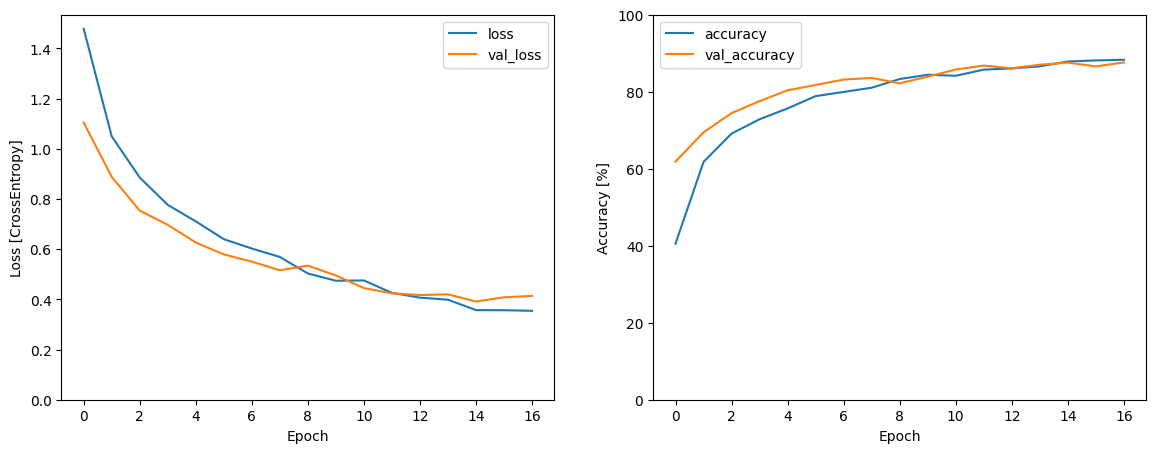

In [45]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [46]:
model.evaluate(test_spectrogram_ds, return_dict=True)

15/15 [==============================] - 5s 313ms/step - loss: 0.3893 - accuracy: 0.8771


{'loss': 0.3892597258090973, 'accuracy': 0.877136766910553}

### Display a confusion matrix

In [47]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

15/15 [==============================] - 5s 304ms/step


In [48]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8845608104477014
Recall: 0.8771367521367521
F1-score: 0.8776281832806611


## Display the confusion matix

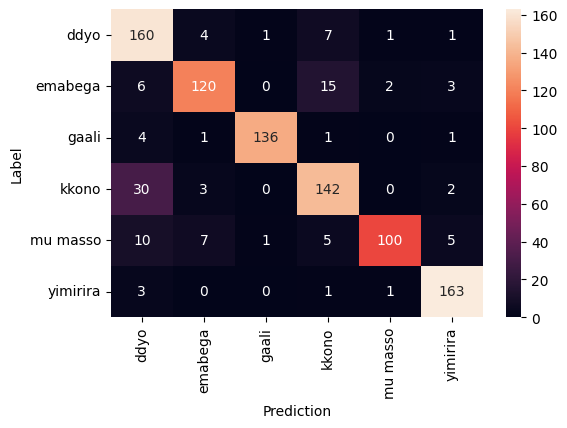

In [49]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [50]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [51]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [52]:
KERAS_MODEL_NAME = "my_model_1.keras"
model.save(KERAS_MODEL_NAME)

In [53]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.301 Megabytes


## TFLite Model for model

In [54]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxeqo1x_z/assets


INFO:tensorflow:Assets written to: /tmp/tmpxeqo1x_z/assets
2024-03-06 23:18:06.997776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-06 23:18:06.997812: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-06 23:18:06.998148: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxeqo1x_z
2024-03-06 23:18:06.999724: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-06 23:18:06.999738: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxeqo1x_z
2024-03-06 23:18:07.002933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-03-06 23:18:07.004378: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-06 23:18:07.058781: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [55]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [56]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [57]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [58]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [59]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [60]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 87%


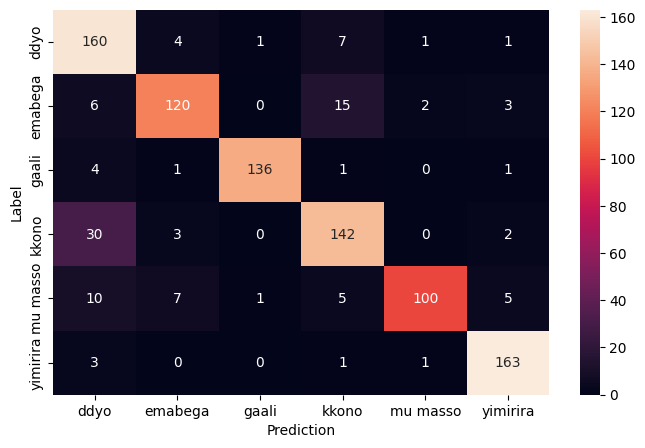

In [61]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [62]:
convert_bytes(get_file_size("model.tflite"), "KB")

File size: 436.039 Kilobytes


## Quntized model

In [63]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpvi06lsvd/assets


INFO:tensorflow:Assets written to: /tmp/tmpvi06lsvd/assets
2024-03-06 23:18:15.824814: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-06 23:18:15.824859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-06 23:18:15.825098: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvi06lsvd
2024-03-06 23:18:15.826776: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-06 23:18:15.826791: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvi06lsvd
2024-03-06 23:18:15.831014: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-06 23:18:15.890213: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvi06lsvd
2024-03-06 23:18:15.910080: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_gj9lwd3/assets


INFO:tensorflow:Assets written to: /tmp/tmp_gj9lwd3/assets
2024-03-06 23:18:19.382164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-06 23:18:19.382200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-06 23:18:19.382407: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_gj9lwd3
2024-03-06 23:18:19.384036: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-06 23:18:19.384050: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_gj9lwd3
2024-03-06 23:18:19.388353: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-06 23:18:19.441722: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_gj9lwd3
2024-03-06 23:18:19.457663: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [64]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 120.414 Kilobytes


In [65]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.8771367521367521


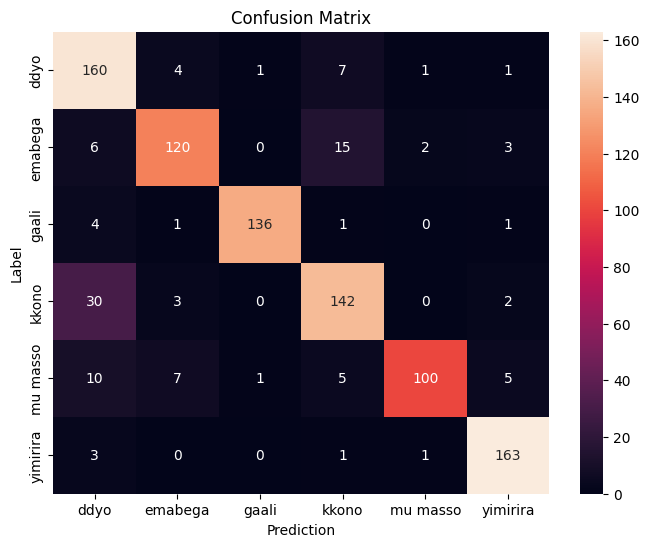

In [66]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [67]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 87%
